In [138]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import obspy
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
import seaborn as sns

## Use data from Xiao et al, 2019

In [144]:
data_folder = './test_data_Venus/venus_interior_xiao_et_al_2019/'
data_template = ['Model_cold_ic_']
all_data = pd.DataFrame()
for subdir, dirs, files in os.walk(data_folder):
    for file in files:
        filepath = subdir + os.sep + file
        good = False
        for template in data_template:
            if template in file:
                good = True
                
        if not good:
            continue
            
        data = pd.read_csv(filepath, header=[0])
        data['file'] = file
        all_data = all_data.append(data)
        
all_data.reset_index(drop=True, inplace=True)
all_data['depth'] = abs(all_data['rad']-all_data['rad'].max())*1e-3
all_data['Vsv'] = all_data.Vs*1e-3
all_data['Vpv'] = all_data.Vp*1e-3
all_data['density'] = all_data.rho*1e-3

<IPython.core.display.Javascript object>


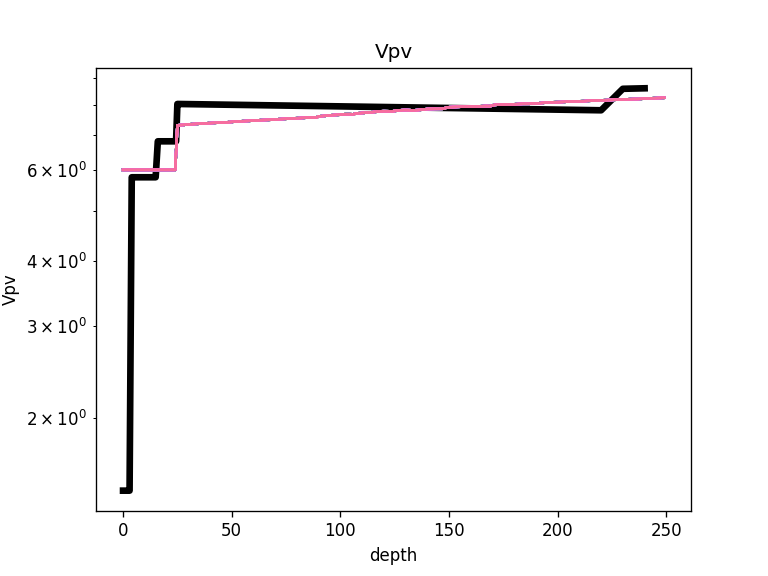

<IPython.core.display.Javascript object>


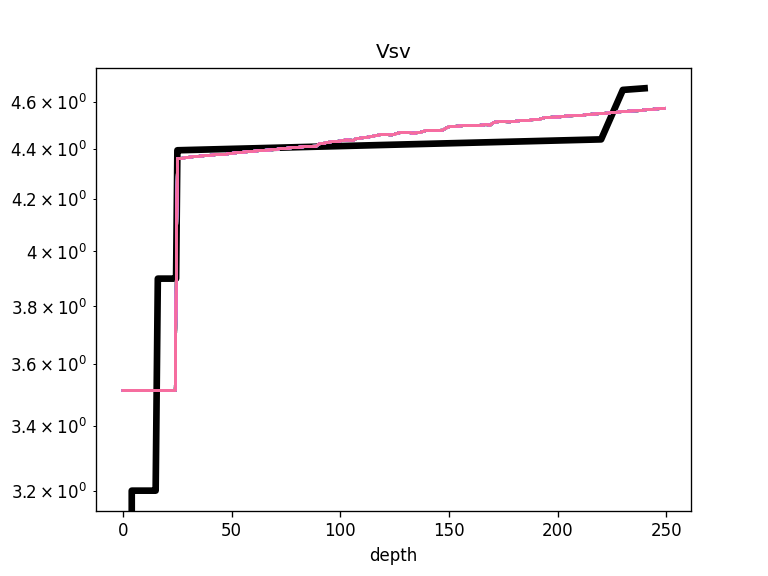

<IPython.core.display.Javascript object>


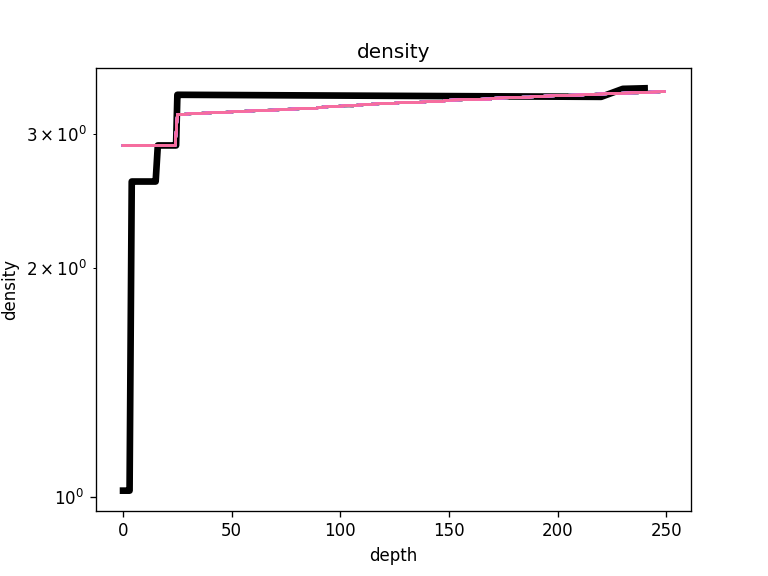

In [165]:
for var in ['Vpv', 'Vsv', 'density']:
    plt.figure()
    sns.lineplot(data=PREM.loc[PREM.depth<250], y=var, x='depth', linewidth=4, color='black', legend=None)
    sns.lineplot(data=all_data.loc[all_data.depth<250], y=var, x='depth', hue='file', legend=None)
    plt.title(var)
    plt.yscale('log')

## Build models from scratch

In [171]:
PREM[['depth', 'Q-kappa', 'Q-mu']].iloc[:50:5]

,depth,Q-kappa,Q-mu
186,0.0,57823.0,0.0
181,5.0,57823.0,600.0
176,10.0,57823.0,600.0
171,15.0,57823.0,600.0
166,20.0,57823.0,600.0
161,25.0,57823.0,600.0
156,30.0,57823.0,600.0
151,35.0,57823.0,600.0
146,70.0,57823.0,600.0
141,120.0,57823.0,80.0


Index(['radius', 'depth', 'density', 'Vpv', 'Vph', 'Vsv', 'Vsh', 'eta', 'Q-mu',
       'Q-kappa'],
      dtype='object')


<IPython.core.display.Javascript object>


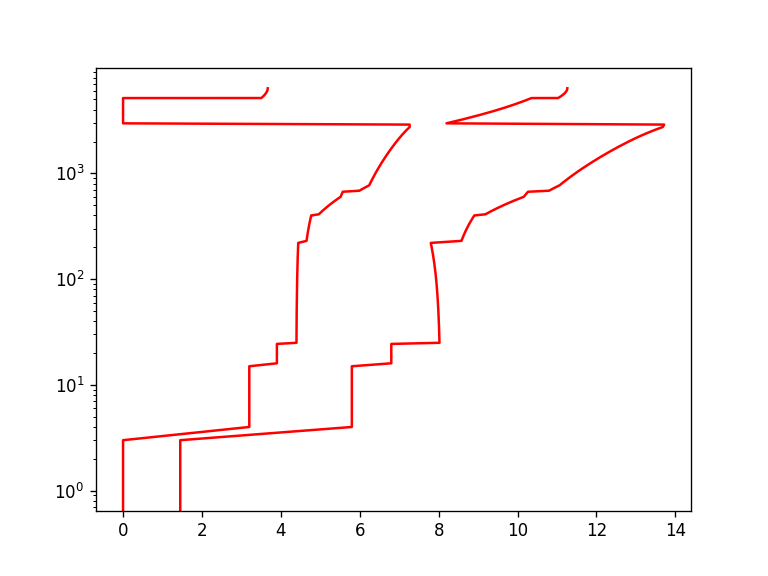

In [4]:
PREM = pd.read_csv('./test_data_Venus/PREM_1s.csv', header=[0])
PREM = PREM.groupby('radius').first().reset_index().sort_values(by='depth')
print(PREM.columns) 

plt.figure()
plt.plot(PREM.Vpv, PREM.depth, color='red', label='Vp')
plt.plot(PREM.Vsv, PREM.depth, color='red', label='Vs')
plt.yscale('log')

In [5]:
mass = PREM.density.iloc[1:].values*1e12*((4/3)*np.pi*(PREM.radius.iloc[:-1].values*1e0)**3 - (4/3)*np.pi*(PREM.radius.iloc[1:].values*1e0)**3)
PREM['mass_layer'] = 0.
PREM.loc[PREM.index<PREM.index.max(), 'mass_layer'] = mass
G = 6.67430e-11  # Gravitational constant (m^3/kg/s^2)
PREM['mass_up_to_layer'] = np.cumsum(PREM.mass_layer.iloc[::-1].values)[::-1]
PREM['gravity'] = G*PREM.mass_up_to_layer/((PREM.radius*1e3)**2)
PREM['thickness'] = 0.
PREM.loc[PREM.depth>0, 'thickness'] = PREM.depth.iloc[1:].values - PREM.depth.iloc[:-1].values
PREM['pressure'] = (PREM.density*1e3*PREM.gravity*PREM.thickness*1e3).cumsum()
PREM.loc[PREM.depth==PREM.depth.max(), 'pressure'] = PREM.pressure.iloc[-2]

In [10]:
PREM

,radius,depth,density,Vpv,Vph,Vsv,Vsh,eta,Q-mu,Q-kappa,mass_layer,mass_up_to_layer,gravity,thickness,pressure
186,6371.0,0.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,0.000000e+00,5.991641e+24,9.852270,0.0,0.000000e+00
185,6370.0,1.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,5.201841e+20,5.991641e+24,9.855364,1.0,1.005247e+07
184,6369.0,2.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,5.200208e+20,5.991121e+24,9.857603,1.0,2.010723e+07
183,6368.0,3.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,5.198575e+20,5.990601e+24,9.859843,1.0,3.016427e+07
182,6367.0,4.0,2.60000,5.80000,5.80000,3.20000,3.20000,1.0,600.0,57823.0,1.324711e+21,5.990081e+24,9.862085,1.0,5.580569e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,400.0,5971.0,13.05366,11.23711,11.23711,3.65027,3.65027,1.0,84.6,1327.7,3.335422e+21,6.840426e+21,2.853441,100.0,3.975875e+11
3,300.0,6071.0,13.06890,11.24809,11.24809,3.65794,3.65794,1.0,84.6,1327.7,2.025487e+21,3.505004e+21,2.599272,100.0,4.009844e+11
2,200.0,6171.0,13.07979,11.25593,11.25593,3.66342,3.66342,1.0,84.6,1327.7,1.040981e+21,1.479517e+21,2.468686,100.0,4.042134e+11
1,100.0,6271.0,13.08632,11.26063,11.26063,3.66670,3.66670,1.0,84.6,1327.7,3.837109e+20,4.385359e+20,2.926920,100.0,4.080437e+11


In [107]:
import numpy as np
from scipy.integrate import odeint
from scipy import interpolate

f = interpolate.interp1d(PREM.pressure.values[::-1], PREM.density.values[::-1], fill_value=(PREM.density.values.min(), PREM.density.values.max()), kind='nearest', bounds_error=False)
def state_eq(p):
    #rho_before = PREM.loc[abs(PREM.pressure-p)==abs(PREM.pressure-p).min(), 'density']
    rho = f(p)*1e3
    return rho

def model(z, x, R, G):
    m, p = z
    rho = state_eq(p)
    if R*(1-x) < 20e3: # Crust
        rho = 2.8e3
        
    dm_dx = 4 * np.pi * (R**3) * (x ** 2) * rho
    dp_dx = -G * (m/(x*R)) * rho
    return [dm_dx, dp_dx]

# Define the boundary conditions
M_venus = 4.8669e24
p_interior_venus, p_surface_Venus = 3e11, 9.3e6
R = 6050.9*1e3
G = 6.67430e-11
    
#M_venus = PREM.mass_up_to_layer.max()
#p_interior_venus, p_surface_Venus = PREM.pressure.max(), PREM.pressure.iloc[1]
#R = 6371*1e3
#G = 6.67430e-11
    
m0, m1 = 0, M_venus
p0, p1 = p_interior_venus, p_surface_Venus

# Define the range of x values to solve over
x_range = np.linspace(1e-2, 1, 500)[::-1]

# Solve the differential equations using odeint
z = odeint(model, [m1, p1], x_range, args=(R, G))

# Extract the solutions for m and p
m_values = z[:, 0]
p_values = z[:, 1]

# Print the solutions for m and p at x=0 and x=1
print(f"m(0) = {m_values[0]:.4f}; m(1) = {m_values[-1]:.4f} ({1e2*m_values[0]/M_venus:.2f}%)")
print(f"p(0) = {p_values[0]:.4f}; p(1) = {p_values[-1]:.4f} ({1e2*p_values[0]/p_surface_Venus:.2f}%)")

m(0) = 4866899999999999583715328.0000; m(1) = 743472107099643212464128.0000 (100.00%)
p(0) = 9300000.0000; p(1) = 432080531120.5808 (100.00%)


In [127]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import interpolate

f = interpolate.interp1d(PREM.pressure.values[::-1], PREM.density.values[::-1], fill_value=(PREM.density.values.min(), PREM.density.values.max()), kind='nearest', bounds_error=False)
def state_eq(p):
    rho = f(p)*1e3
    return rho

def model(t, z, R, G):
    m, p = z
    rho = state_eq(p)
    if R*(1-t) < 20e3: # Crust
        rho = 2.8e3
        
    dm_dt = 4 * np.pi * (R**3) * (t ** 2) * rho
    dp_dt = -G * (m/(t*R)) * rho
    return [dm_dt, dp_dt]

# Define the boundary conditions
M_venus = 4.8669e24
p_interior_venus, p_surface_Venus = 3e11, 9.3e6
R = 6050.9*1e3
G = 6.67430e-11

m0, m1 = 0, M_venus
p0, p1 = p_interior_venus, p_surface_Venus

# Define the range of t values to solve over
xmin = 1e-10
t_eval = np.linspace(xmin, 1, 500)[::-1]
t_span = [t_eval[0], t_eval[-1]]

# Solve the differential equations using solve_ivp
sol = solve_ivp(model, t_span, [m1, p1], args=(R, G), t_eval=t_eval, )

# Extract the solutions for m and p
m_values = sol.y[0]
p_values = sol.y[1]

# Print the solutions for m and p at t=0 and t=1
print(f"m(0) = {m_values[0]:.4f}; m(1) = {m_values[-1]:.4e} ({1e2*m_values[0]/M_venus:.2e}%)")
print(f"p(0) = {p_values[0]:.4f} ({1e2*p_values[0]/p_interior_venus:.2e}%); p(1) = {p_values[-1]:.4e} ({1e2*p_values[0]/p_surface_Venus:.2e}%)")


m(0) = 4866899999999999583715328.0000; m(1) = 7.4839e+23 (1.00e+02%)
p(0) = 9300000.0000 (3.10e-03%); p(1) = 2.4242e+12 (1.00e+02%)


<IPython.core.display.Javascript object>


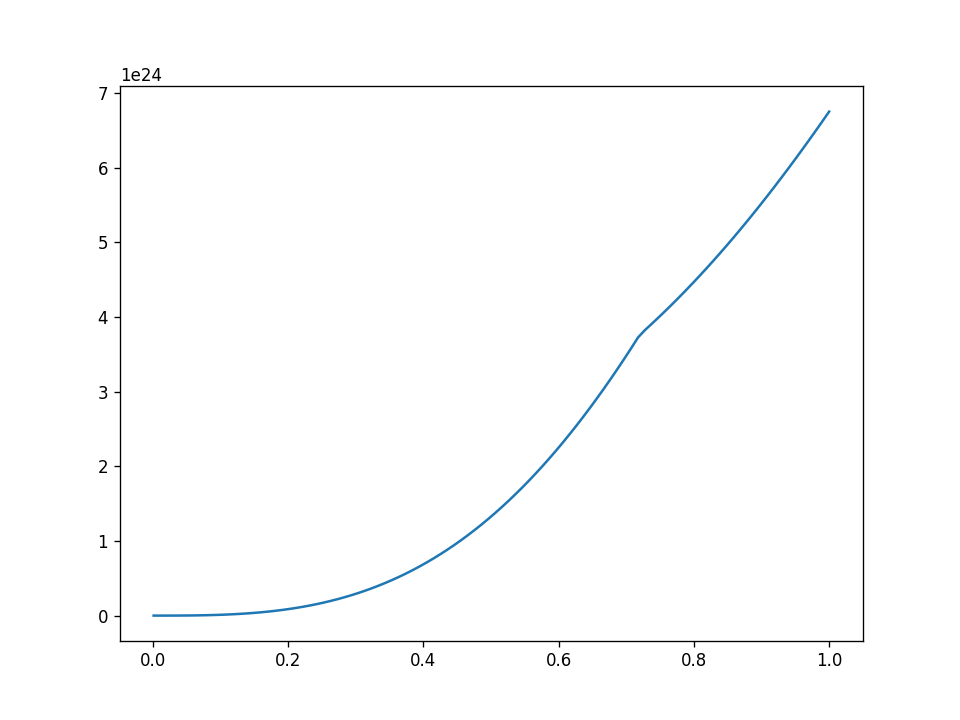

<IPython.core.display.Javascript object>


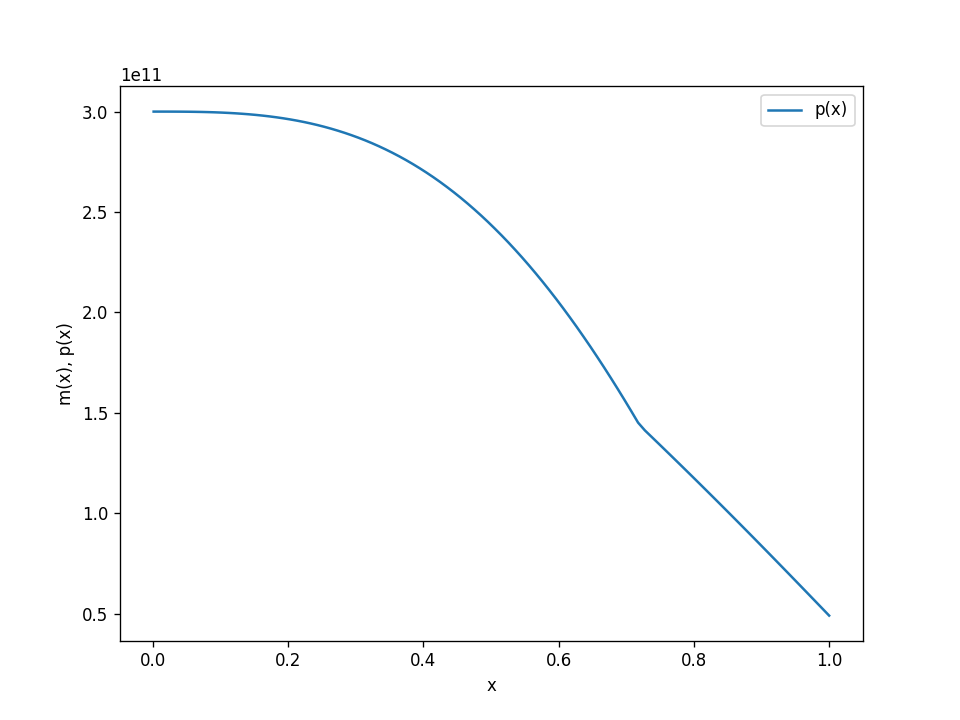

In [131]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

f = interpolate.interp1d(PREM.pressure.values[::-1], PREM.density.values[::-1], fill_value=(PREM.density.values.min(), PREM.density.values.max()), kind='nearest', bounds_error=False)
def state_eq(p):
    rho = f(p)*1e3
    return rho

# Define the system of ODEs
def ode_system(y, x, R, G):
    m, p = y
    rho = state_eq(p)
    dm_dx = 4 * np.pi * R**3 * x**2 * rho
    dp_dx = -G * m * rho / (x * R)
    return [dm_dx, dp_dx]

# Define the residual function for the least squares problem
def residual(params, x, boundary_conditions):
    # Unpack the parameters
    m_initial, p_initial = params
    # Integrate the ODE system using an ODE solver
    y = odeint(ode_system, [m_initial, p_initial], x, args=(R, G))
    # Calculate the residuals based on the boundary conditions
    residuals = [
        y[0, 0] - boundary_conditions[0],  # m(0) = 0
        y[0, 1] - boundary_conditions[1],  # m(1) = 1
        y[1, 1] - boundary_conditions[2]   # p(1) = 0
    ]
    return residuals

# Define the constants and boundary conditions
#rho = 1.0
R = 6050.9*1e3
G = 6.67430e-11
M_venus = 4.8669e24
p_interior_venus, p_surface_Venus = 3e11, 9.3e6
m0, m1 = 0, M_venus
p0, p1 = p_interior_venus, p_surface_Venus

boundary_conditions = [m0, m1, p1]

# Define the x values where you want to compute the solution
x = np.linspace(1e-3, 1, 100)

# Initial guesses for m(0) and p(0)
m_initial_guess = m0
p_initial_guess = p0
initial_guess = [m_initial_guess, p_initial_guess]

# Solve the least squares problem
result = least_squares(residual, initial_guess, args=(x, boundary_conditions))

# Extract the solution
solution = result.x

# Integrate the ODEs using the obtained parameters
from scipy.integrate import odeint
y = odeint(ode_system, solution, x, args=(R, G))

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x, y[:, 0], label='m(x)')
plt.figure(figsize=(8, 6))
plt.plot(x, y[:, 1], label='p(x)')
plt.xlabel('x')
plt.ylabel('m(x), p(x)')
plt.legend()
plt.show()


In [132]:
result.x

array([0.e+00, 3.e+11])

In [123]:
from tqdm import tqdm
rho_values = []
rho_values_Earth = []
pressure_values = []
pressure_values_Earth = []
mass_values = []
mass_values_Earth = []
R = 6050.9
#R = 6371
for x, p, m in tqdm(zip(x_range, p_values, m_values), total=len(x_range)):
    #rho_values.append( PREM.loc[abs(PREM.pressure-p)==abs(PREM.pressure-p).min(), 'density'].iloc[0] )
    rho_values.append( f(p) )
    rho_values_Earth.append( PREM.loc[abs(PREM.radius-x*R)==abs(PREM.radius-x*R).min(), 'density'].iloc[0] )
    pressure_values.append( p )
    pressure_values_Earth.append( PREM.loc[abs(PREM.radius-x*R)==abs(PREM.radius-x*R).min(), 'pressure'].iloc[0] )
    mass_values.append( m )
    mass_values_Earth.append( PREM.loc[abs(PREM.radius-x*R)==abs(PREM.radius-x*R).min(), 'mass_up_to_layer'].iloc[0] )

100%|██████████| 500/500 [00:02<00:00, 240.33it/s]


<IPython.core.display.Javascript object>


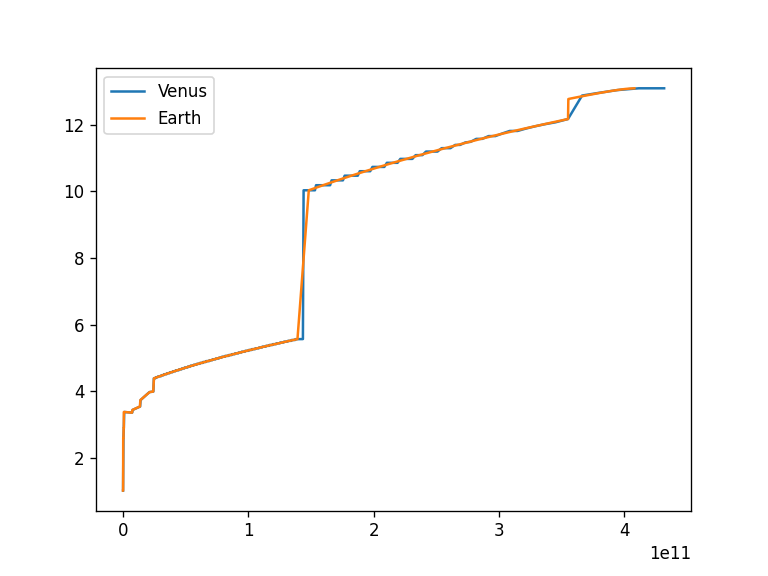

<IPython.core.display.Javascript object>


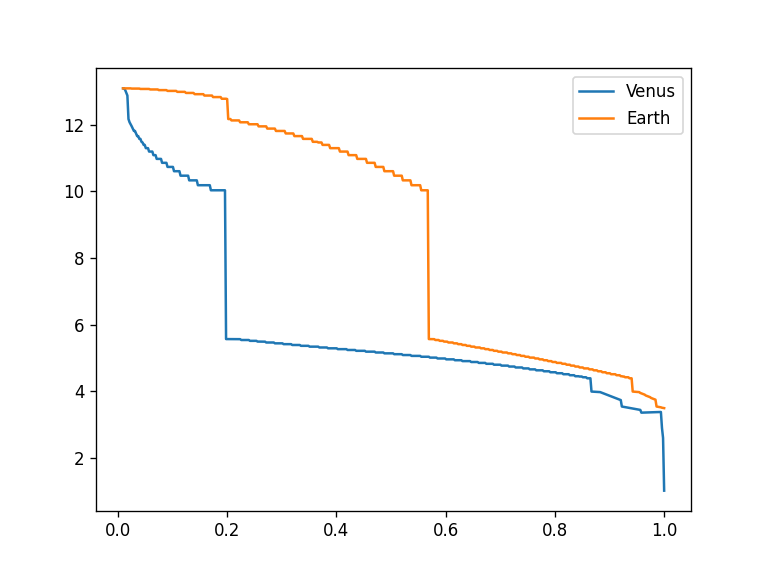

<IPython.core.display.Javascript object>


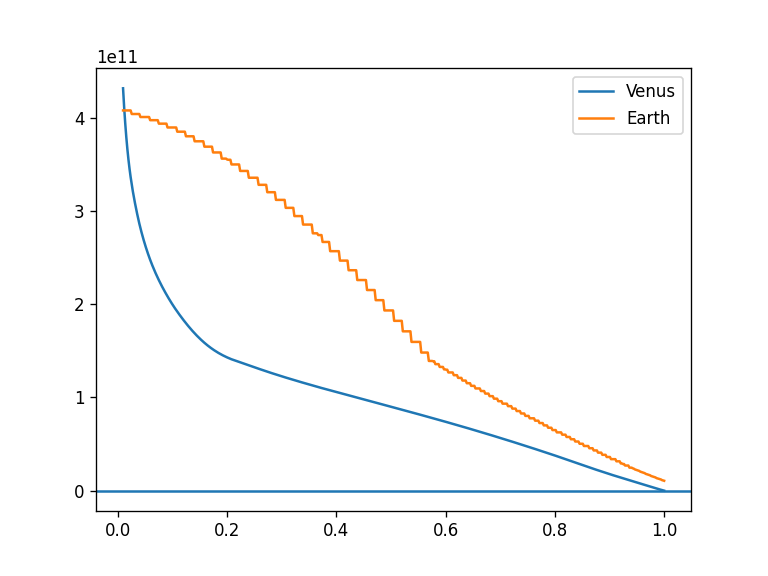

<IPython.core.display.Javascript object>


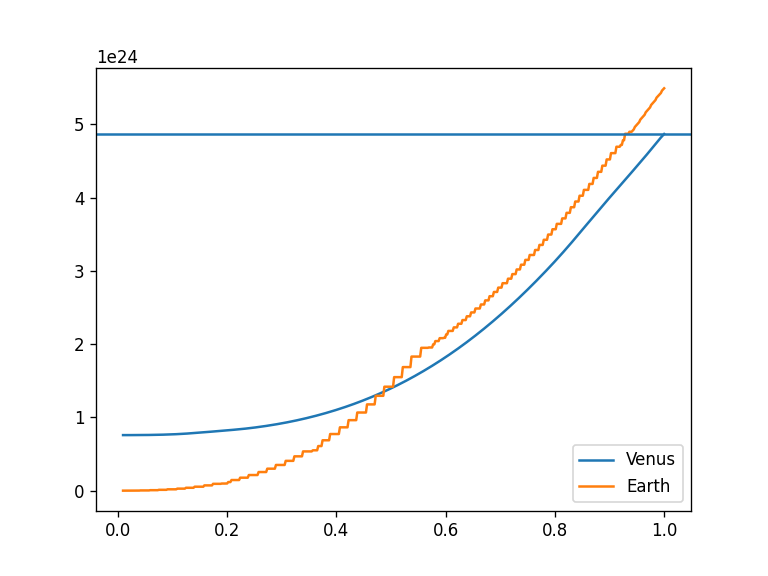

In [124]:
plt.figure()
plt.plot(p_values, rho_values, label='Venus')
plt.plot(PREM.pressure.values, PREM.density.values, label='Earth')
plt.legend()

plt.figure()
plt.plot(x_range, rho_values, label='Venus')
plt.plot(x_range, rho_values_Earth, label='Earth')
plt.legend()

plt.figure()
plt.plot(x_range, pressure_values, label='Venus')
plt.plot(x_range, pressure_values_Earth, label='Earth')
plt.legend()
plt.axhline(p1)

plt.figure()
plt.plot(x_range, mass_values, label='Venus')
plt.plot(x_range, mass_values_Earth, label='Earth')
plt.legend()
plt.axhline(m1)

In [109]:
import numpy as np
from scipy.integrate import solve_bvp

def ode_system(x, y):
    y1, y2 = y
    dy1dx = 3*(x**2)*y2
    dy2dx = -2*y1*y2/(x**2)
    return np.vstack((dy1dx, dy2dx))

def boundary_conditions(ya, yb):
    return np.array([ya[0], yb[0] - 1.0, ya[1] - 250, yb[1] - 1e-6])

x_start = 0
x_end = 1
num_points = 100

x_mesh = np.linspace(x_start, x_end, num_points)
y_guess = np.zeros((2, x_mesh.size))

sol = solve_bvp(ode_system, boundary_conditions, x_mesh, y_guess)

# Access the solution
x_values = x_mesh
y1_values, y2_values = sol.sol(x_values)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(x_values, y1_values, label='y1(x)')
plt.plot(x_values, y2_values, label='y2(x)')
plt.xlabel('x')
plt.legend()
plt.grid()
plt.show()


/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


ValueError: `bc` return is expected to have shape (2,), but actually has (4,).

<IPython.core.display.Javascript object>


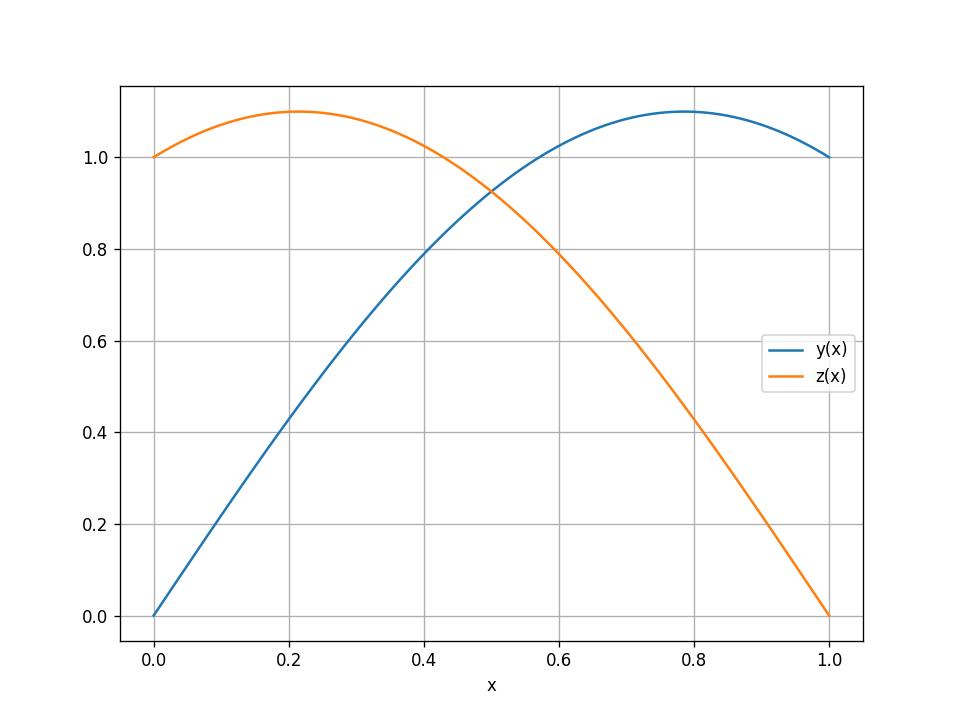

In [110]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Define the system of ODEs
def ode_system(x, y):
    y1, y2, z1, z2 = y
    dy1dx = y2
    dy2dx = -k**2 * y1
    dz1dx = z2
    dz2dx = -k**2 * z1
    return np.vstack((dy1dx, dy2dx, dz1dx, dz2dx))

# Define the boundary conditions
def boundary_conditions(ya, yb):
    return np.array([ya[0] - y_a, yb[0] - y_b, ya[2] - z_a, yb[2] - z_b])

# Constants
k = 2.0  # Adjust this value as needed
x_start = 0
x_end = 1
y_a = 0  # Initial value for y at x_start
y_b = 1  # Value for y at x_end
z_a = 1  # Initial value for z at x_start
z_b = 0  # Value for z at x_end
num_points = 100

# Set up the mesh
x_mesh = np.linspace(x_start, x_end, num_points)
y_guess = np.zeros((4, x_mesh.size))

# Solve the BVP
sol = solve_bvp(ode_system, boundary_conditions, x_mesh, y_guess)

# Access the solution
x_values = x_mesh
y1_values, y2_values, z1_values, z2_values = sol.sol(x_values)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_values, y1_values, label='y(x)')
plt.plot(x_values, z1_values, label='z(x)')
plt.xlabel('x')
plt.legend()
plt.grid()
plt.show()


In [27]:
import numpy as np
import scipy.integrate as spi

# Constants
G = 6.67430e-11  # Gravitational constant (m^3/kg/s^2)
pi = np.pi

# Venus parameters
M_v = 4.8675e24  # Venus mass (kg)
R_v = 6.0518e6   # Venus mean radius (m)

# Pressure scaling
def pressure_factor(r):
    # Calculate pressure factor at depth r
    return 1.0 - (r / R_v)

# Create a function for rescaling density and seismic velocity
def rescale_density_and_velocity(r):
    factor = pressure_factor(r)
    closest_PREM = PREM.loc[abs(PREM.depth-r/1e3)==abs(PREM.depth-r/1e3).min()]
    rho_PREM = closest_PREM['density'].iloc[0]
    Vp_PREM = closest_PREM['Vpv'].iloc[0]
    Vs_PREM = closest_PREM['Vsv'].iloc[0]
    print(r, factor, rho_PREM, rho_PREM * (1.0 / factor))
    return rho_PREM * (1.0 / factor), Vp_PREM * np.sqrt(1.0 / factor), Vs_PREM * np.sqrt(1.0 / factor)

# Calculate the pressure-rescaled profiles
depths = np.linspace(0, R_v, 2)  # Depth values from surface to center
depths = [0., 100., ]

rescaled_density_profile, rescaled_vp_profile, rescaled_vs_profile = zip(*[rescale_density_and_velocity(r) for r in depths])
rescaled_density_profile = list(rescaled_density_profile)
rescaled_vp_profile = list(rescaled_vp_profile)
rescaled_vs_profile = list(rescaled_vs_profile)

# Now you have rescaled_density_profile and rescaled_velocity_profile as functions of depth within Venus.

# Example: Print the rescaled density and velocity profiles at various depths
#for depth, density, velocity in zip(depths, rescaled_density_profile, rescaled_velocity_profile):
#    print(f"Depth: {depth:.2f} m, Rescaled Density: {density:.2f} kg/m^3, Rescaled Velocity: {velocity:.2f} m/s")


0.0 1.0 1.02 1.02


In [79]:
PREM

,radius,depth,density,Vpv,Vph,Vsv,Vsh,eta,Q-mu,Q-kappa,thickness,mass,gravity
0,6371.0,0.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,1.0,5.201841e+20,855.357347
1,6370.0,1.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,1.0,5.200208e+20,855.357326
2,6369.0,2.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,1.0,5.198575e+20,855.357305
3,6368.0,3.0,1.02000,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0,0.0,0.000000e+00,0.000000
4,6368.0,3.0,2.60000,5.80000,5.80000,3.20000,3.20000,1.0,600.0,57823.0,1.0,1.324711e+21,2180.322489
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,400.0,5971.0,13.05366,11.23711,11.23711,3.65027,3.65027,1.0,84.6,1327.7,100.0,2.025487e+21,844919.063956
195,300.0,6071.0,13.06890,11.24809,11.24809,3.65794,3.65794,1.0,84.6,1327.7,100.0,1.040981e+21,771980.260856
196,200.0,6171.0,13.07979,11.25593,11.25593,3.66342,3.66342,1.0,84.6,1327.7,100.0,3.837109e+20,640250.487098
197,100.0,6271.0,13.08632,11.26063,11.26063,3.66670,3.66670,1.0,84.6,1327.7,100.0,5.482498e+19,365918.367988


In [70]:
PREM[PREM.index<PREM.index.max(), 'mass']

TypeError: '(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False]), 'mass')' is an invalid key